## Zonal mean diagnostics

This notebook compares the zonal mean diagnostics simulated by different schemes with atmospheric forcing from JRA55-do.
This example plots the zonal mean mixed layer depth (MLD).

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
sys.path.append(os.environ['GOTMWORK_ROOT']+'/tools', )
from gotmanalysis import GOTMMap
%matplotlib inline

In [2]:
# parameters
casename = 'JRA55-do_Global_dampV5d_3h'
diagname = 'mld_deltaR_mean'

In [3]:
# paths
s2data_root = os.environ['GOTMFIG_ROOT']+'/data/'+casename
fig_root = os.environ['GOTMFIG_ROOT']+'/'+casename
os.makedirs(s2data_root, exist_ok=True)
os.makedirs(fig_root, exist_ok=True)

In [4]:
# lists
timetag_list = ['20090101-20090131',
                '20090201-20090228',
                '20090301-20090331',
                '20090401-20090430',
                '20090501-20090531',
                '20080601-20080630',
                '20080701-20080731',
                '20080801-20080831',
                '20080901-20080930',
                '20081001-20081031',
                '20081101-20081130',
                '20081201-20081231']
ntag = len(timetag_list)
turbmethod_list = ['KPP-CVMix',
                   'KPP-ROMS',
                   'EPBL',
                   'SMC',
                   'K-EPSILON-SG',
                   'KPPLT-EFACTOR',
                   'KPPLT-ENTR',
                   'KPPLT-RWHGK',
                   'EPBL-LT',
                   'SMCLT',
                   'OSMOSIS']
legend_list = ['KPP-CVMix',
               'KPP-ROMS',
               'ePBL',
               'SMC-KC94',
               '$k$-$\epsilon$-SG95',
               'KPPLT-VR12',
               'KPPLT-LF17',
               'KPPLT-R16',
               'ePBL-LT',
               'SMCLT-H15',
               'OSMOSIS']
nm = len(turbmethod_list)
bcolor = ['lightcyan','lightblue','greenyellow','lightpink','palegoldenrod',
          'turquoise', 'deepskyblue','royalblue','forestgreen','firebrick','mediumpurple']
month_labels = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', \
                'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

### Load data 

In [5]:
# get data and save in a two dimensional list
gmobj_data_arr = []
for j in np.arange(ntag):
    timetag = timetag_list[j]
    # read data
    gmobj_data_tmp = []
    for i in np.arange(nm):
        tmname = turbmethod_list[i]
        s2data_name = s2data_root+'/VR1m_DT600s_'+timetag+'/data_map_'+ \
                      diagname+'_'+tmname+'.npz'
        gmobj_tmp = GOTMMap().load(s2data_name)
        gmobj_data_tmp.append(gmobj_tmp)
    gmobj_data_arr.append(gmobj_data_tmp)

### Compute the mean over all non-LT schemes 

In [6]:
# mean (over all non-Langmuir turbulent methods) of var at each month, [12]*GOTMMap
gmobj_m_mon_nlt = []
# loop over time tags
for j in np.arange(ntag):
    ncase = gmobj_data_arr[j][0].data.size
    tmp = np.zeros([nm, ncase])
    # loop over turbulent methods
    for i in np.arange(nm):
        tmp[i,:] = gmobj_data_arr[j][i].data
    # mean of all non-Langmuir cases
    diag0_nlt = np.mean(tmp[0:5,:], axis=0)
    # get lon, lat etc.
    lon = gmobj_data_arr[j][0].lon
    lat = gmobj_data_arr[j][0].lat
    name = gmobj_data_arr[j][0].name
    units = gmobj_data_arr[j][0].units
    # create GOTMMap object
    gmobj_tmp_nlt = GOTMMap(data=diag0_nlt, lon=lon, lat=lat, name=name, units=units)
    # append to list
    gmobj_m_mon_nlt.append(gmobj_tmp_nlt)

### Functions 

In [7]:
@ticker.FuncFormatter
def major_formatter(x, pos):
    if x > 0:
        return '{:d}$^\circ$N'.format(int(x))
    elif x == 0:
        return '{:d}$^\circ$'.format(int(x))
    else:
        return '{:d}$^\circ$S'.format(int(-x))

### Figure 1: Differences in the mean MLD

The differences of zonal mean MLD in each scheme from the mean averaged over all the non-LT schemes. 

/Users/qingli/models/gotm/gotmwork/tools/gotmanalysis.py:361: RuntimeWarning: Mean of empty slice
  val[i] = np.nanmean(tmp_arr)


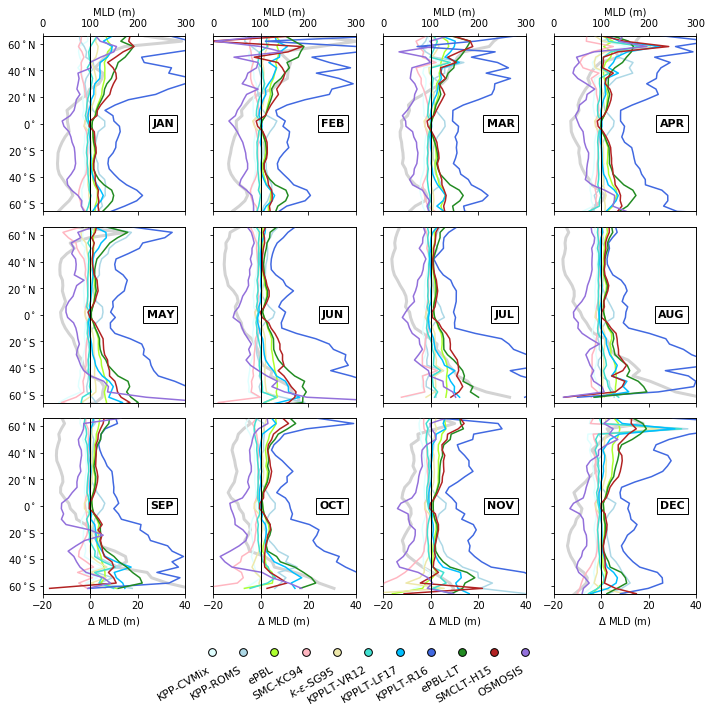

In [8]:
# create figure
ncol = 4
nrow = int(ntag/ncol)
fig_width = 10
fig_height = 10

# plot figure
f, axarr = plt.subplots(nrow, ncol, sharex='col', sharey='row')
f.set_size_inches(fig_width, fig_height)

for i in np.arange(ntag):
    # plot figure
    m = i//ncol
    n = i%ncol
    zm_lat, zm_val0 = gmobj_m_mon_nlt[i].zonal_mean()
    par1 = axarr[m,n].twiny()
    par1.plot(zm_val0, zm_lat, 'lightgray', linestyle='-', linewidth=3)
    par1.set_xlim([0, 300])
    par1.set_xlabel('MLD (m)')
    if m >= 1:
        par1.get_xaxis().set_visible(False)
    for j in np.arange(nm):
        zm_lat, zm_val = gmobj_data_arr[i][j].zonal_mean()
        axarr[m,n].plot(zm_val-zm_val0, zm_lat, bcolor[j], linewidth=1.5)
    axarr[m,n].set_zorder(par1.get_zorder()+1)
    axarr[m,n].patch.set_visible(False)
    axarr[m,n].set_xlim([-20, 40])
    axarr[m,n].set_ylim([-66, 66])
    axarr[m,n].get_yaxis().set_major_formatter(major_formatter)
    axarr[m,n].axvline(0, color='black', linewidth=1)
    if m == nrow-1:
        axarr[m,n].set_xlabel('$\Delta$ MLD (m)')

    # add month
    axarr[m,n].text(0.92, 0.5, month_labels[i], transform=axarr[m,n].transAxes,
                   fontsize=11, color='k', fontweight='bold', va='center', ha='right',
                   bbox=dict(boxstyle="square",ec='k',fc='w'))

# reduce margin
plt.tight_layout()

# legend
plt.subplots_adjust(bottom=0.17)
xx = np.arange(nm)
xx = xx*0.22-0.01
yy = -np.ones(xx.size)*0.4
for i in np.arange(nm):
    axarr[2,1].text(xx[i], yy[i], legend_list[i], color='black',
                  transform=axarr[2,1].transAxes, fontsize=11, rotation=30,
                  va='top', ha='right')
    axarr[2,1].scatter(xx[i], yy[i]+0.07, s=60, c=bcolor[i], edgecolors='k', linewidth=1,
                     transform=axarr[2,1].transAxes, clip_on=False)

# save figure
figname = fig_root+'/zonal_mean_'+diagname+'.png'
plt.savefig(figname, dpi = 300)

### Figure 2: Root-mean-square differences in the mean MLD

The root-mean-square differences of zonal mean MLD in each scheme from the mean averaged over all the non-LT schemes. 

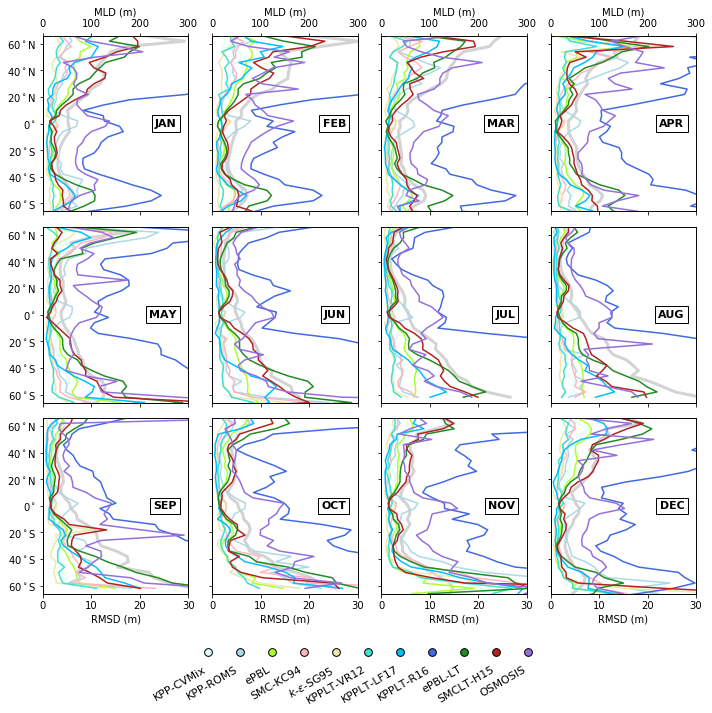

In [9]:
# create figure
ncol = 4
nrow = int(ntag/ncol)
fig_width = 10
fig_height = 10

# plot figure
f, axarr = plt.subplots(nrow, ncol, sharex='col', sharey='row')
f.set_size_inches(fig_width, fig_height)

for i in np.arange(ntag):
    # plot figure
    m = i//ncol
    n = i%ncol
    zm_lat, zm_val0 = gmobj_m_mon_nlt[i].zonal_mean()
    par1 = axarr[m,n].twiny()
    par1.plot(zm_val0, zm_lat, 'lightgray', linestyle='-', linewidth=3)
    par1.set_xlim([0, 300])
    par1.set_xlabel('MLD (m)')
    if m >= 1:
        par1.get_xaxis().set_visible(False)
    for j in np.arange(nm):
        data_tmp = (gmobj_data_arr[i][j].data-gmobj_m_mon_nlt[i].data)**2
        lon = gmobj_data_arr[i][0].lon
        lat = gmobj_data_arr[i][0].lat
        name = gmobj_data_arr[i][0].name
        units = gmobj_data_arr[i][0].units
        gmobj_tmp = GOTMMap(data=data_tmp, lon=lon, lat=lat, name=name, units=units)
        zm_lat, zm_val = gmobj_tmp.zonal_mean()
        axarr[m,n].plot(np.sqrt(zm_val), zm_lat, bcolor[j], linewidth=1.5)
    axarr[m,n].set_zorder(par1.get_zorder()+1)
    axarr[m,n].patch.set_visible(False)
    axarr[m,n].set_xlim([0, 30])
    axarr[m,n].set_ylim([-66, 66])
    axarr[m,n].get_yaxis().set_major_formatter(major_formatter)
    axarr[m,n].axvline(0, color='black', linewidth=1)
    if m == nrow-1:
        axarr[m,n].set_xlabel('RMSD (m)')

    # add month
    axarr[m,n].text(0.92, 0.5, month_labels[i], transform=axarr[m,n].transAxes,
                   fontsize=11, color='k', fontweight='bold', va='center', ha='right',
                   bbox=dict(boxstyle="square",ec='k',fc='w'))

# reduce margin
plt.tight_layout()

# legend
plt.subplots_adjust(bottom=0.17)
xx = np.arange(nm)
xx = xx*0.22-0.03
yy = -np.ones(xx.size)*0.4
for i in np.arange(nm):
    axarr[2,1].text(xx[i], yy[i], legend_list[i], color='black',
                  transform=axarr[2,1].transAxes, fontsize=11, rotation=30,
                  va='top', ha='right')
    axarr[2,1].scatter(xx[i], yy[i]+0.07, s=60, c=bcolor[i], edgecolors='k', linewidth=1,
                     transform=axarr[2,1].transAxes, clip_on=False)

# save figure
figname = fig_root+'/zonal_RMSD_'+diagname+'.png'
plt.savefig(figname, dpi = 300)